In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.9.0+cu126
CUDA available: True


In [2]:
import zipfile

# Only run this if you haven't extracted yet
zip_path = "/content/Colorize.zip"

if os.path.exists(zip_path) and not os.path.exists("/content/landscape Images"):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall("/content")
    print("✓ Extracted successfully!")
else:
    print("✓ Files already extracted or zip not found")

print("Available folders:", os.listdir("/content"))

✓ Extracted successfully!
Available folders: ['.config', 'Colorize.zip', 'landscape Images', 'sample_data']


In [3]:
GRAY_DIR = "/content/landscape Images/gray"
COLOR_DIR = "/content/landscape Images/color"

print(f"Gray images: {len(os.listdir(GRAY_DIR))}")
print(f"Color images: {len(os.listdir(COLOR_DIR))}")

# Preview a sample
sample_gray = os.listdir(GRAY_DIR)[0]
sample_color = os.listdir(COLOR_DIR)[0]
print(f"\nSample files:")
print(f"  Gray: {sample_gray}")
print(f"  Color: {sample_color}")

Gray images: 7129
Color images: 7129

Sample files:
  Gray: 581.jpg
  Color: 581.jpg


In [4]:
class LandscapeColorizationDataset(Dataset):
    def __init__(self, gray_dir, color_dir, img_size=224):
        self.gray_dir = gray_dir
        self.color_dir = color_dir
        self.gray_files = sorted(os.listdir(gray_dir))
        self.color_files = sorted(os.listdir(color_dir))
        self.img_size = img_size

        assert len(self.gray_files) == len(self.color_files), "Dataset mismatch!"

    def __len__(self):
        return len(self.gray_files)

    def __getitem__(self, idx):
        color_path = os.path.join(self.color_dir, self.color_files[idx])

        # Load ground truth RGB
        color = cv2.imread(color_path)
        color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
        color = cv2.resize(color, (self.img_size, self.img_size))

        # Convert to LAB - use ONLY the color image
        lab = cv2.cvtColor(color, cv2.COLOR_RGB2LAB).astype(np.float32)
        L = lab[:, :, 0]           # lightness
        AB = lab[:, :, 1:]         # a,b channels

        # Normalization
        L = L / 100.0              # L is 0-100
        AB = (AB - 128) / 128.0    # to [-1,1]

        # Tensors
        L = torch.tensor(L).unsqueeze(0).float()
        AB = torch.tensor(AB).permute(2,0,1).float()

        return L, AB

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.net(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, 2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Pad difference
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNetColorizationNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.inc = DoubleConv(1, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        # Decoder
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        self.outc = nn.Conv2d(64, 2, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        x = self.outc(x)
        return self.tanh(x)

In [6]:
dataset = LandscapeColorizationDataset(GRAY_DIR, COLOR_DIR)
loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

print(f"✓ Dataset size: {len(dataset)}")
print(f"✓ Batches per epoch: {len(loader)}")

# Test dataset
L_test, AB_test = dataset[0]
print(f"✓ L shape: {L_test.shape}, AB shape: {AB_test.shape}")

✓ Dataset size: 7129
✓ Batches per epoch: 446
✓ L shape: torch.Size([1, 224, 224]), AB shape: torch.Size([2, 224, 224])


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = UNetColorizationNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

print(f"✓ Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")

Using device: cuda
✓ Model initialized with 31,036,546 parameters


In [10]:
epochs = 30

print(f"\n{'='*50}")
print(f"Starting Training for {epochs} epochs")
print(f"{'='*50}\n")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (L_batch, AB_batch) in enumerate(loader):
        L_batch = L_batch.to(device)
        AB_batch = AB_batch.to(device)

        optimizer.zero_grad()
        preds = model(L_batch)
        loss = criterion(preds, AB_batch)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()

        # Print progress every 100 batches
        if batch_idx % 100 == 0:
            print(f"  Epoch [{epoch+1}/{epochs}] Batch [{batch_idx}/{len(loader)}] Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(loader)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"✓ Epoch [{epoch+1}/{epochs}] Avg Loss: {avg_loss:.4f} | LR: {current_lr:.6f}")

    # Update learning rate
    scheduler.step(avg_loss)

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint_path = f'/content/checkpoint_epoch_{epoch+1}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print(f"💾 Checkpoint saved: {checkpoint_path}\n")

print(f"\n{'='*50}")
print("✓ Training Completed!")
print(f"{'='*50}\n")


Starting Training for 30 epochs

  Epoch [1/30] Batch [0/446] Loss: 0.0949
  Epoch [1/30] Batch [100/446] Loss: 0.0145
  Epoch [1/30] Batch [200/446] Loss: 0.0122
  Epoch [1/30] Batch [300/446] Loss: 0.0112
  Epoch [1/30] Batch [400/446] Loss: 0.0071
✓ Epoch [1/30] Avg Loss: 0.0111 | LR: 0.001000
  Epoch [2/30] Batch [0/446] Loss: 0.0075
  Epoch [2/30] Batch [100/446] Loss: 0.0070
  Epoch [2/30] Batch [200/446] Loss: 0.0081
  Epoch [2/30] Batch [300/446] Loss: 0.0107
  Epoch [2/30] Batch [400/446] Loss: 0.0104
✓ Epoch [2/30] Avg Loss: 0.0093 | LR: 0.001000
  Epoch [3/30] Batch [0/446] Loss: 0.0136
  Epoch [3/30] Batch [100/446] Loss: 0.0069
  Epoch [3/30] Batch [200/446] Loss: 0.0130
  Epoch [3/30] Batch [300/446] Loss: 0.0105
  Epoch [3/30] Batch [400/446] Loss: 0.0095
✓ Epoch [3/30] Avg Loss: 0.0089 | LR: 0.001000
  Epoch [4/30] Batch [0/446] Loss: 0.0061
  Epoch [4/30] Batch [100/446] Loss: 0.0089
  Epoch [4/30] Batch [200/446] Loss: 0.0130
  Epoch [4/30] Batch [300/446] Loss: 0.01

In [11]:
def lab_to_rgb(L, AB):
    """Convert LAB to RGB for visualization"""
    L = (L * 100).astype("uint8")
    AB = (AB * 128 + 128).astype("uint8")

    lab = np.zeros((L.shape[0], L.shape[1], 3), dtype="uint8")
    lab[:,:,0] = L
    lab[:,:,1:] = AB

    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return rgb


def visualize_results(model, dataset, device, num_samples=5):
    """Visualize random samples from the dataset"""
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        idx = np.random.randint(len(dataset))
        L_img, AB_true = dataset[idx]

        with torch.no_grad():
            AB_pred = model(L_img.unsqueeze(0).to(device)).cpu().squeeze(0).numpy()

        L_np = L_img.squeeze().numpy()
        AB_pred_np = AB_pred.transpose(1,2,0)
        AB_true_np = AB_true.numpy().transpose(1,2,0)

        rgb_pred = lab_to_rgb(L_np, AB_pred_np)
        rgb_true = lab_to_rgb(L_np, AB_true_np)

        axes[i, 0].imshow(L_np, cmap="gray")
        axes[i, 0].set_title("Grayscale Input")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(rgb_true)
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(rgb_pred)
        axes[i, 2].set_title("Model Prediction")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

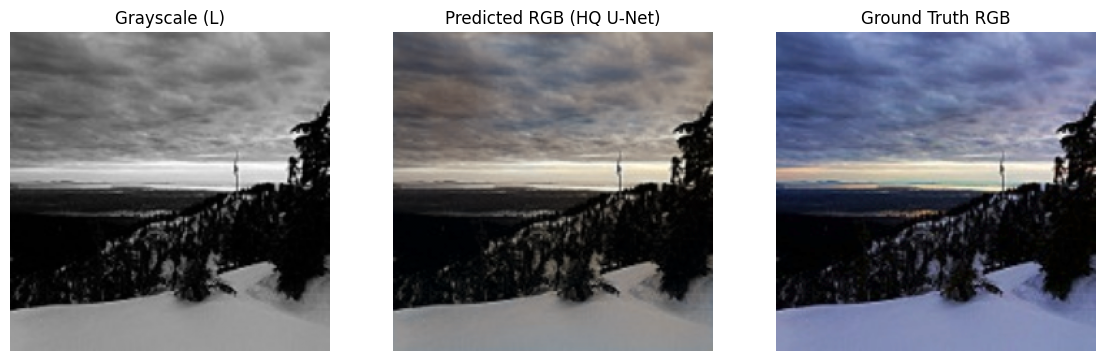

In [12]:
idx = 50   # try different indices

L_img, AB_true = dataset[idx]

model.eval()
with torch.no_grad():
    AB_pred = model(L_img.unsqueeze(0).to(device)).cpu().squeeze(0).numpy()  # (2,H,W)

L_np = L_img.squeeze().numpy()                           # (H,W)
AB_pred_np = AB_pred.transpose(1, 2, 0)                 # (H,W,2)
AB_true_np = AB_true.numpy().transpose(1, 2, 0)

rgb_pred = lab_to_rgb(L_np, AB_pred_np)
rgb_true = lab_to_rgb(L_np, AB_true_np)

plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.title("Grayscale (L)")
plt.imshow(L_np, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Predicted RGB (HQ U-Net)")
plt.imshow(rgb_pred)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Ground Truth RGB")
plt.imshow(rgb_true)
plt.axis("off")

plt.show()

Generating sample predictions...



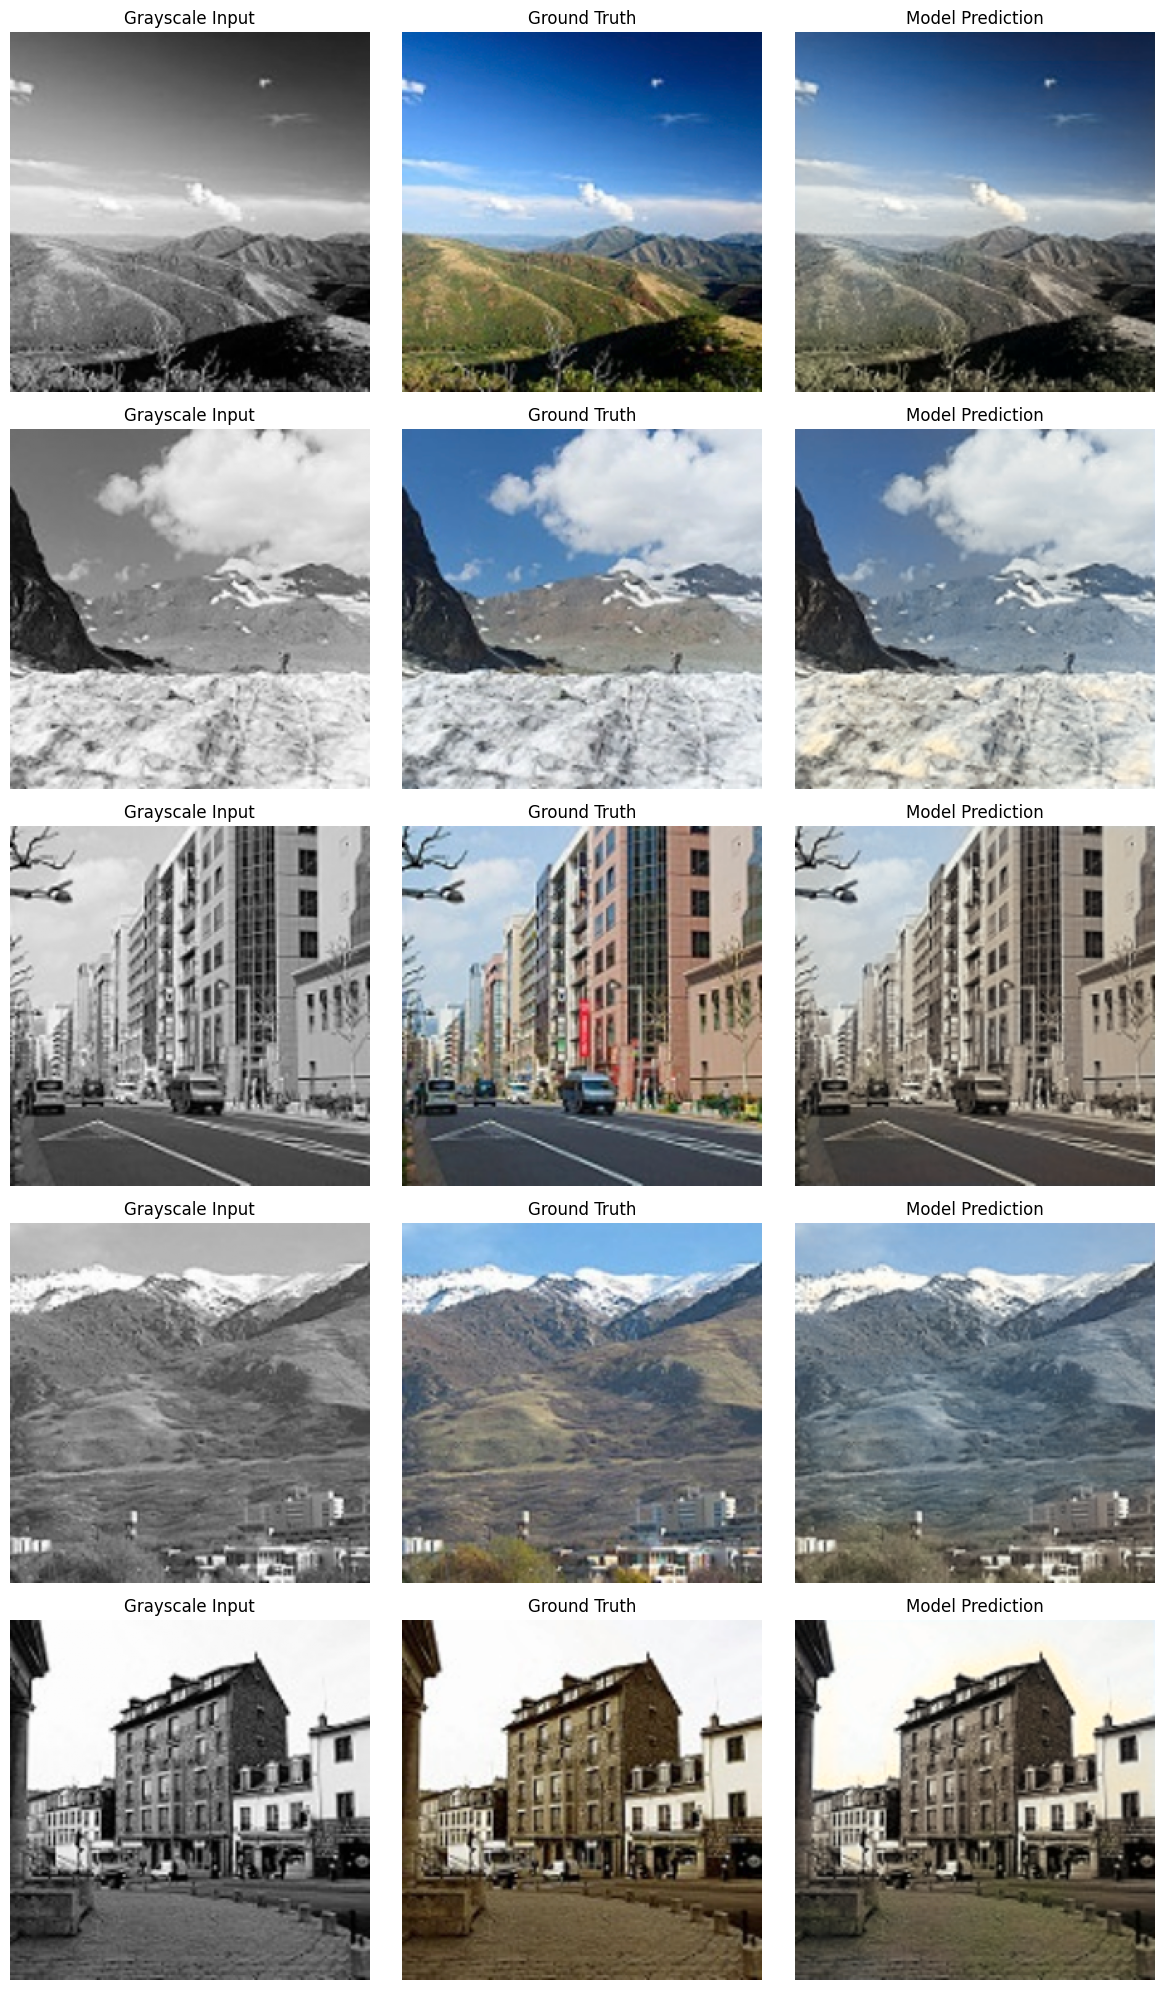

In [13]:
print("Generating sample predictions...\n")
visualize_results(model, dataset, device, num_samples=5)

In [14]:
# Save the final model
torch.save(model.state_dict(), '/content/colorization_model_final.pth')
print("✓ Final model saved!")

# Download it to your computer
from google.colab import files
files.download('/content/colorization_model_final.pth')

✓ Final model saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>